In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML


In [2]:
def open_grid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=decode_times)
    grid['ds']=grid['ds'].drop_dims(['ny','nx'])
    grid['ds']=grid['ds'].drop_vars(['tile'])
    grid['nyp']=grid['ds'].nyp.data[-1]+1
    grid['nxp']=grid['ds'].nxp.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(1,nyp+1,2))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(nxp=slice(2,nxp+1,2),nyp=slice(2,nyp+1,2))
    grid['Cu'] = grid['ds'].isel(nxp=slice(0,nxp+1,2),nyp=slice(1,nyp+1,2))
    grid['Cv'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(0,nyp+1,2))
    return grid



In [3]:
def wright_eos(T,S,p):
  """
  
 **********************************************************************
   The subroutines in this file implement the equation of state for   *
   sea water using the formulae given by  Wright, 1997, J. Atmos.     *
   Ocean. Tech., 14, 735-740.  Coded by R. Hallberg, 7/00.            *
 ***********************************************************************
    Converted to Python from F90 by M Harrison 10/11.
 Calculate seawater equation of state, given T[degC],S[PSU],p[Pa]
 Returns density [kg m-3]
 
 ***********************************************************************
 
 """

  a0 = 7.057924e-4; a1 = 3.480336e-7; a2 = -1.112733e-7;
  b0 = 5.790749e8;  b1 = 3.516535e6;  b2 = -4.002714e4;
  b3 = 2.084372e2;  b4 = 5.944068e5;  b5 = -9.643486e3;
  c0 = 1.704853e5;  c1 = 7.904722e2;  c2 = -7.984422;
  c3 = 5.140652e-2; c4 = -2.302158e2; c5 = -3.079464;

  al0 = a0 + a1*T +a2*S
  p0  = b0 + b4*S + T * (b1 + T*(b2 + b3*T) + b5*S)
  lam = c0 +c4*S + T * (c1 + T*(c2 + c3*T) + c5*S)
  I_denom = 1.0 / (lam + al0*(p+p0))  
  rho = (p + p0) * I_denom

  return rho 

In [4]:
def open_dataset(path,fields,grid,MF=False):
    if MF:
        ds=xr.open_mfdataset(path,decode_times=False)
    else:
        ds=xr.open_dataset(path,decode_times=False)
    
    tracer_list=[];uv_list=[]
    for f in fields:
        for fnam,val in zip(f.keys(),f.values()):
            if val=='h':tracer_list.append(fnam)
            if val=='Cu':uv_list.append(fnam)
            if val=='Cv':uv_list.append(fnam)
                
    ds_tr = xr.merge([ds, grid['h']])
    ds_u= xr.merge([ds,grid['Cu']])
    ds_v= xr.merge([ds,grid['Cv']])
    return {'ds_tr':ds_tr,'ds_u':ds_u,'ds_v':ds_v,'tracers':tracer_list,'uv':uv_list}

In [5]:
path_regional_grid='./ocean_hgrid.nc'
regional_grid=open_grid(path_regional_grid)
regional_grid['ds']=regional_grid['ds'].load()

In [6]:
ds_topo=xr.open_dataset('PIG2kmp1_bbar_taub_m1_10nxny_bedelev_outcrp.nc')

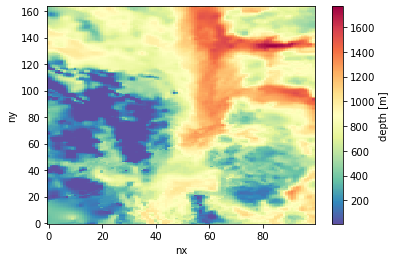

In [7]:
ds_topo['depth'].plot(cmap='Spectral_r')


In [8]:
#Linear profile in T and S
#This must be consistent with runtine MOM6 configuration
T_top=-1.9;T_bot=-1.9
S_top=33.8;S_bot=34.55


In [9]:
def eos_linear(T,S):
    RHO0_T0_S0=1000.
    DRHO_DT=-0.0383569483
    DRHO_DS=0.805876093
    return RHO0_T0_S0 + DRHO_DT*T + DRHO_DS*S

In [10]:
#Dpth=ds_topo['depth'].isel(lonh=slice(40,42),lath=slice(31,32)).data
Dpth=ds_topo['depth'].data
(nj,ni)=Dpth.shape
#Number of model layers
nk=25
T_prof=np.linspace(T_top,T_bot,nk)
S_prof=np.linspace(S_top,S_bot,nk)
T=np.tile(T_prof[:,np.newaxis,np.newaxis],(1,nj,ni))
S=np.tile(S_prof[:,np.newaxis,np.newaxis],(1,nj,ni))
rho_ref = eos_linear(T_prof,S_prof) # reference profile
Dpth_max=Dpth.max()
zi=np.linspace(0.,Dpth_max,nk+1)
h=zi[1:]-zi[0:-1]
R=np.tile(rho_ref[:,np.newaxis,np.newaxis],(1,nj,ni)) #layer density
H=np.tile(h[:,np.newaxis,np.newaxis],(1,nj,ni)) #layer thickness
ZI=np.cumsum(H,axis=0) 
Z_top=np.zeros((1,nj,ni))
ZI=np.concatenate((Z_top,ZI)) #Interface positions

In [11]:
Rlay=xr.DataArray(rho_ref,coords={'Layer':rho_ref},dims=('Layer'))
ds = xr.Dataset({'R':Rlay})
ds['Layer'].encoding['_FillValue']=1.e20
ds['R'].encoding['_FillValue']=1.e20
ds.to_netcdf('Vertical_coordinate.nc',format='NETCDF3_CLASSIC')

In [12]:
#Make interfaces consistent with topography and free surface
def limit_depths(zint,D,z_surf):
    nk=zint.shape[0]
    zi=np.zeros(zint.shape)
    for k in np.arange(nk):
        zk=1.0*zint[k,:]
        zk[zk<z_surf]=z_surf[zk<z_surf]
        zk[zk>D]=D[zk>D]
        zi[k,:]=zk
    zi[-1,:]=D
    return zi

In [13]:
thick=ds_topo['h_shelf'].data
#thick=ds_topo['h_shelf'].isel(lonh=slice(40,42),lath=slice(31,32)).data

In [14]:
#Ice shelf density
#must be consistent with online MOM6 configuration
rho_ice=917.0
rho_ref=eos_linear(T_prof.mean(),S_prof.mean())
#First-guess displacement using average profile density
z_disp=rho_ice/rho_ref*thick
ZI_OCN=limit_depths(ZI,Dpth,z_disp)

In [15]:
sfc=np.zeros(z_disp.shape)
ZI_DISP=limit_depths(ZI,z_disp,sfc)

In [16]:
def disp_pressure(z_ice,rho,zi):
    "Calculate the pressure at depth z_ice"
    grav=9.8
    h=zi[1:,:]-zi[:-1,:] 
    rho_h=rho*h
    r_dz=np.sum(rho_h,axis=0)
    p_disp=r_dz*grav
    return p_disp

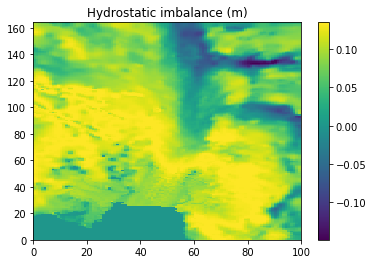

In [18]:
grav=9.8
p_ice=rho_ice*grav*thick
rbar = R[0,:]
z_disp=rho_ice/rbar*thick
p_disp=disp_pressure(z_disp,R,ZI_DISP)
residual=(p_ice-p_disp)/grav/rbar
plt.pcolormesh(residual);plt.colorbar()
txt=plt.title('Hydrostatic imbalance (m)')

In [19]:
tol=1.e-7
err=np.std(residual)
print('std(residual)=',err)
cnt=1
while err>tol:
    z_disp = z_disp+residual*0.5
    #z_disp[z_disp>Dpth]=Dpth[z_disp>Dpth]
    ZI_DISP=limit_depths(ZI,z_disp,sfc)
    p_disp=disp_pressure(z_disp,R,ZI_DISP)
    residual=(p_ice-p_disp)/grav/rbar
    #residual[z_disp>Dpth]=0
    err=np.std(residual)
    print(cnt,' std(residual)=',err)
    cnt=cnt+1

std(residual)= 0.05247974795239687
1  std(residual)= 0.17266929213184182
2  std(residual)= 0.08628193123055461
3  std(residual)= 0.04311462555495167
4  std(residual)= 0.02154415086463004
5  std(residual)= 0.010765498475251696
6  std(residual)= 0.005379462741246492
7  std(residual)= 0.0026880891003626044
8  std(residual)= 0.0013432239024637616
9  std(residual)= 0.0006712018709366726
10  std(residual)= 0.00033539601703214264
11  std(residual)= 0.000167595610117161
12  std(residual)= 8.374663625167993e-05
13  std(residual)= 4.184774890923428e-05
14  std(residual)= 2.0911097437607387e-05
15  std(residual)= 1.0449164001610736e-05
16  std(residual)= 5.221391536208329e-06
17  std(residual)= 2.6091014844715966e-06
18  std(residual)= 1.3037540725795109e-06
19  std(residual)= 6.514789375505242e-07
20  std(residual)= 3.255405402094279e-07
21  std(residual)= 1.6267086305228252e-07
22  std(residual)= 8.128575659883789e-08


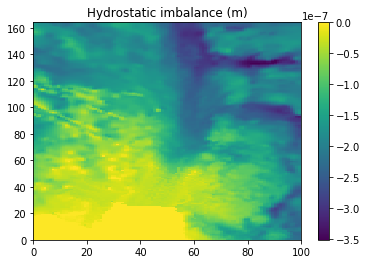

In [20]:
plt.pcolormesh(residual)
plt.colorbar()
txt=plt.title('Hydrostatic imbalance (m)')

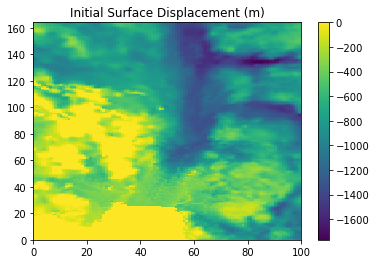

In [21]:
z_disp[z_disp>Dpth]=Dpth[z_disp>Dpth]
plt.pcolormesh(-z_disp);plt.colorbar()
txt=plt.title('Initial Surface Displacement (m)')

In [22]:
ZI_OCN=limit_depths(ZI,Dpth,z_disp)

In [23]:
H=ZI_OCN[1:,:]-ZI_OCN[:-1,:]
Angstrom=1.e-9
H[H<Angstrom]=Angstrom
z_disp_new=Dpth-H.sum(axis=0)

In [24]:
Temp=xr.DataArray(T,coords={'i':np.arange(ni)+0.5,'j':np.arange(nj)+0.5,'k':np.arange(nk)+0.5},dims=('k','j','i'))
Salt=xr.DataArray(S,coords={'i':np.arange(ni)+0.5,'j':np.arange(nj)+0.5,'k':np.arange(nk)+0.5},dims=('k','j','i'))

In [25]:
Hlay=xr.DataArray(H,coords={'i':np.arange(ni)+0.5,'j':np.arange(nj)+0.5,'k':np.arange(nk)+0.5},dims=('k','j','i'))

In [26]:
ds = xr.Dataset({'temp':Temp,'salt':Salt})
ds['i'].encoding['_FillValue']=1.e20
ds['j'].encoding['_FillValue']=1.e20
ds['k'].encoding['_FillValue']=1.e20
ds['temp'].encoding['_FillValue']=1.e20
ds['salt'].encoding['_FillValue']=1.e20

In [27]:
#not needed at runtime
ds.to_netcdf('temp_ic.nc',format='NETCDF3_CLASSIC')

In [28]:
ds = xr.Dataset({'h':Hlay})
ds['i'].encoding['_FillValue']=1.e20
ds['j'].encoding['_FillValue']=1.e20
ds['k'].encoding['_FillValue']=1.e20
ds['h'].encoding['_FillValue']=1.e20

In [29]:
#not needed at runtime
ds.to_netcdf('thickness_ic.nc',format='NETCDF3_CLASSIC')

In [30]:
Sfc=xr.DataArray(-z_disp_new,coords={'i':np.arange(ni)+0.5,'j':np.arange(nj)+0.5},dims=('j','i'))

In [31]:
ds = xr.Dataset({'SSH':Sfc})
ds['i'].encoding['_FillValue']=1.e20
ds['j'].encoding['_FillValue']=1.e20
ds['SSH'].encoding['_FillValue']=1.e20

In [32]:
#needed at runtime
ds.to_netcdf('sfc_ic.nc',engine='netcdf4')